3: What variables have more importance in determining the Total amount for a fair? What do these specific variables represent in the real world and in the dataset? Now, if we decide we are including daily covid death and covid cases #’s, does the model improve? What does this show regarding the impact between NYC Covid cases and the Taxi business?

## a) ##

In [1]:
import warnings
warnings.filterwarnings('ignore')
import datetime as dt
import pandas as pd
import numpy as np
from plotnine import *

from sklearn.linear_model import LinearRegression # Linear Regression Model

from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation
from sklearn.metrics import mean_absolute_error


from sklearn.model_selection import train_test_split # simple TT split cv


from sklearn.decomposition import PCA

In [2]:
TaxiJulySet= pd.read_csv("yellow_tripdata_2021-07.csv")
TaxiJuneSet= pd.read_csv("yellow_tripdata_2021-06.csv")
TaxiMaySet= pd.read_csv("yellow_tripdata_2021-05.csv")

In [3]:
bigSet = pd.concat([TaxiJulySet,TaxiJuneSet,TaxiMaySet],axis = 0)
# bigSet = TaxiJulySet
bigSet['time_of_trip'] = (pd.to_datetime(bigSet["tpep_dropoff_datetime"]) - pd.to_datetime(bigSet["tpep_pickup_datetime"])).dt.total_seconds()

In [4]:
bigSet.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,time_of_trip
0,1.0,2021-07-01 00:08:51,2021-07-01 00:13:05,1.0,0.8,1.0,N,90,68,1.0,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5,254.0
1,1.0,2021-07-01 00:22:39,2021-07-01 00:25:58,1.0,0.9,1.0,N,113,90,2.0,5.0,3.0,0.5,0.0,0.0,0.3,8.8,2.5,199.0
2,1.0,2021-07-01 00:48:33,2021-07-01 00:54:58,1.0,2.8,1.0,N,88,232,2.0,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5,385.0
3,1.0,2021-07-01 00:59:44,2021-07-01 01:07:09,1.0,1.4,1.0,N,79,249,1.0,7.0,3.0,0.5,1.5,0.0,0.3,12.3,2.5,445.0
4,1.0,2021-07-01 00:08:35,2021-07-01 00:16:28,0.0,2.0,1.0,N,142,238,1.0,8.5,3.0,0.5,0.0,0.0,0.3,12.3,2.5,473.0


In [5]:
CovidSet= pd.read_csv("covidDataByDay.csv")

bigSet['tpep_pickup_datetime'] = pd.to_datetime(bigSet['tpep_pickup_datetime']).dt.date
CovidSet['date_of_interest'] = pd.to_datetime(CovidSet['date_of_interest']).dt.date
bigSet=bigSet.rename(columns={"tpep_pickup_datetime": "date"})
CovidSet=CovidSet.rename(columns={"date_of_interest": "date"})

In [6]:
mergeSet = CovidSet.merge(bigSet, on='date', how='inner')
mergeSet.head()
mergeSet = mergeSet.dropna()

In [7]:
mergeSet.head()

,date,CASE_COUNT,PROBABLE_CASE_COUNT,HOSPITALIZED_COUNT,DEATH_COUNT,PROBABLE_DEATH_COUNT,CASE_COUNT_7DAY_AVG,ALL_CASE_COUNT_7DAY_AVG,HOSP_COUNT_7DAY_AVG,DEATH_COUNT_7DAY_AVG,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,time_of_trip
0,2021-04-30,963,314,94,38,1,1050,1384,117,30,...,2.0,8.5,0.5,0.5,0.00,0.0,0.3,12.30,2.5,546.0
1,2021-04-30,963,314,94,38,1,1050,1384,117,30,...,1.0,6.5,0.5,0.5,2.06,0.0,0.3,12.36,2.5,416.0
2,2021-04-30,963,314,94,38,1,1050,1384,117,30,...,2.0,4.5,0.5,0.5,0.00,0.0,0.3,8.30,2.5,214.0
3,2021-04-30,963,314,94,38,1,1050,1384,117,30,...,1.0,6.5,0.5,0.5,2.06,0.0,0.3,12.36,2.5,465.0
4,2021-04-30,963,314,94,38,1,1050,1384,117,30,...,1.0,48.0,0.5,0.5,0.00,0.0,0.3,51.80,2.5,1759.0


## Without COVID ##

In [8]:
predictors = ["passenger_count","trip_distance","time_of_trip","RatecodeID","payment_type","tip_amount","tolls_amount"]

testSplitDecimal = .1

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

y_pred = lr.predict(Xz_test)
y_predTrain = lr.predict(Xz_train)


testMSE = mean_squared_error(y_test,y_pred)
trainMSE = mean_squared_error(y_train,y_predTrain)

testr2 = r2_score(y_test,y_pred)
trainr2 = r2_score(y_train,y_predTrain)

In [9]:
coefficients = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
print(coefficients)

print("TEST")
print(testMSE)
print(testr2)

print("TRAIN")
print(trainr2)
print(trainMSE)

       Coef             Name
0  0.082776  passenger_count
1  3.554899    trip_distance
2  0.897942     time_of_trip
3  1.183589       RatecodeID
4  1.159034     payment_type
5  7.034940       tip_amount
6  5.039394     tolls_amount
TEST
60.254908114784634
0.7124436304803352
TRAIN
0.6542082045301509
74.18379345973146


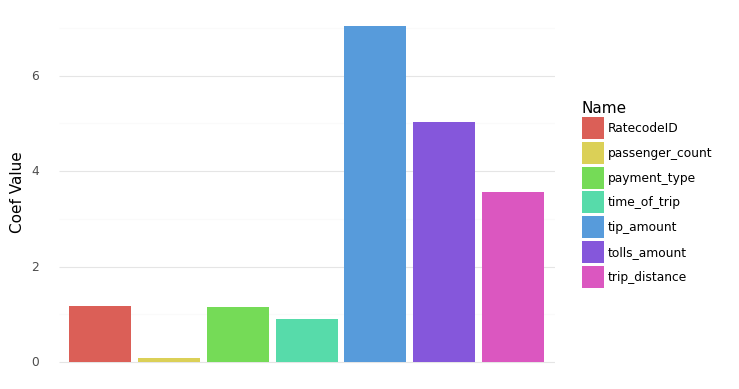

<ggplot: (120526200558)>

In [10]:
coefficients1 = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
ggplot(aes(x="Name", weight="Coef"), coefficients1) + geom_bar(aes(fill = "Name")) + theme_minimal() + labs(x = "Coefficent's Name",y = "Coef Value") + theme(panel_grid_major_x = element_blank(),
        axis_title_x=element_blank(),
        axis_text_x=element_blank())

In [11]:
print(np.mean(mergeSet["total_amount"]))
print(np.std(mergeSet["total_amount"]))
print(np.max(mergeSet["total_amount"]))

18.793118124455663
14.629899632388813
5954.0


In [12]:
predictors = ["passenger_count","trip_distance","time_of_trip","RatecodeID","payment_type","tip_amount","tolls_amount"]


X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

predicted = lr.predict(Xz_test)

pca = PCA()
pca.fit(X_train[predictors])

pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_, "pc": range(1,8),"cum_var": pca.explained_variance_ratio_.cumsum()})
pcaDF.head()


,expl_var,pc,cum_var
0,9.999960e-01,1,0.999996
1,3.209254e-06,2,0.999999
2,5.040411e-07,3,1.000000
3,1.676061e-07,4,1.000000
4,7.886418e-08,5,1.000000


In [13]:
np.max(pd.DataFrame(pca.components_,columns=X_train.columns,index = range(1,8)))

passenger_count    0.009909
trip_distance      0.985617
time_of_trip       1.000000
RatecodeID         0.997414
payment_type       0.080775
tip_amount         0.142752
tolls_amount       0.961983
dtype: float64

In [14]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(7)]
most_important_names = [predictors[most_important[i]] for i in range(7)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(7)}

df = pd.DataFrame(sorted(dic.items()))
print(df)

     0                1
0  PC1     time_of_trip
1  PC2    trip_distance
2  PC3       tip_amount
3  PC4     tolls_amount
4  PC5  passenger_count
5  PC6       RatecodeID
6  PC7     payment_type


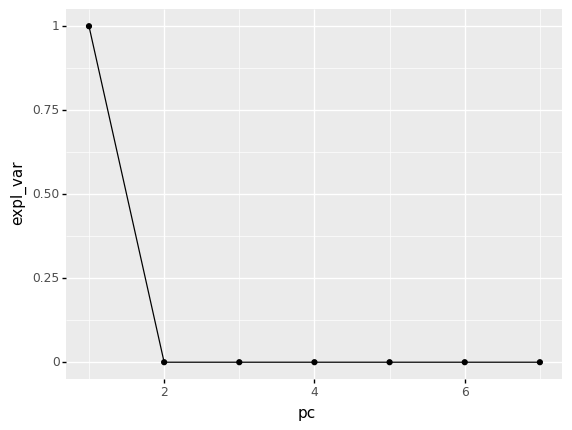

<ggplot: (120518556450)>

In [15]:
(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point())

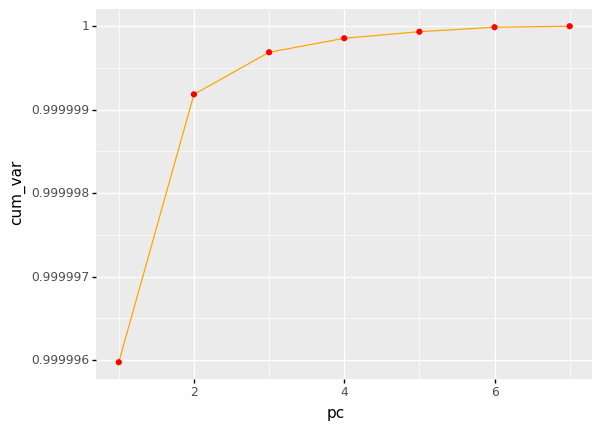

In [16]:
plot1 = (ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line(color = "Orange") +
 geom_point(color = "Red"))
print(plot1)

In [17]:
predictors = ["time_of_trip","trip_distance","RatecodeID","tip_amount","tolls_amount"]
# trip_distance      0.985519
# time_of_trip       1.000000
# RatecodeID         0.997399
# tip_amount         0.143267
# tolls_amount       0.961486

testSplitDecimal = .1

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

y_pred = lr.predict(Xz_test)
y_predTrain = lr.predict(Xz_train)


testMSE = mean_squared_error(y_test,y_pred)
trainMSE = mean_squared_error(y_train,y_predTrain)

testr2 = r2_score(y_test,y_pred)
trainr2 = r2_score(y_train,y_predTrain)


coefficients = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
print(coefficients)

print("TEST")
print(testMSE)
print(testr2)

print("TRAIN")
print(trainr2)
print(trainMSE)

       Coef           Name
0  0.924364   time_of_trip
1  3.670098  trip_distance
2  1.216263     RatecodeID
3  6.436293     tip_amount
4  5.185893   tolls_amount
TEST
59.78379811691754
0.7121167926862624
TRAIN
0.6492163539553013
75.32777073516155


In [18]:
predictors = ["time_of_trip","trip_distance","tip_amount","tolls_amount","passenger_count"]
# PC1     time_of_trip
# PC2    trip_distance
# PC3       tip_amount
# PC4     tolls_amount
# PC5  passenger_count


testSplitDecimal = .1

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

y_pred = lr.predict(Xz_test)
y_predTrain = lr.predict(Xz_train)


testMSE = mean_squared_error(y_test,y_pred)
trainMSE = mean_squared_error(y_train,y_predTrain)

testr2 = r2_score(y_test,y_pred)
trainr2 = r2_score(y_train,y_predTrain)


coefficients = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
print(coefficients)

print("TEST")
print(testMSE)
print(testr2)

print("TRAIN")
print(trainr2)
print(trainMSE)

       Coef             Name
0  0.553233     time_of_trip
1  7.076277    trip_distance
2  5.033628       tip_amount
3  3.657404     tolls_amount
4  0.033660  passenger_count
TEST
622.6344460205387
-1.9680856310535524
TRAIN
0.7457881321862596
54.53020725666284


## With COIVD ##

In [19]:
predictors = ["CASE_COUNT","HOSPITALIZED_COUNT","DEATH_COUNT","CASE_COUNT_7DAY_AVG","HOSP_COUNT_7DAY_AVG","DEATH_COUNT_7DAY_AVG",
              "passenger_count","trip_distance","time_of_trip","RatecodeID","payment_type","tip_amount","tolls_amount"]

testSplitDecimal = .1

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

y_pred = lr.predict(Xz_test)
y_predTrain = lr.predict(Xz_train)


testMSE = mean_squared_error(y_test,y_pred)
trainMSE = mean_squared_error(y_train,y_predTrain)

testr2 = r2_score(y_test,y_pred)
trainr2 = r2_score(y_train,y_predTrain)

In [20]:
coefficients = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
print(coefficients)

print("TEST")
print(testMSE)
print(testr2)

print("TRAIN")
print(trainr2)
print(trainMSE)

        Coef                  Name
0   0.047369            CASE_COUNT
1   0.052283    HOSPITALIZED_COUNT
2   0.062564           DEATH_COUNT
3  -0.041217   CASE_COUNT_7DAY_AVG
4  -0.056316   HOSP_COUNT_7DAY_AVG
5  -0.153160  DEATH_COUNT_7DAY_AVG
6   0.080665       passenger_count
7   3.516088         trip_distance
8   0.893431          time_of_trip
9   1.146411            RatecodeID
10  1.117497          payment_type
11  6.942350            tip_amount
12  5.134492          tolls_amount
TEST
66.16593826382505
0.6857820537080613
TRAIN
0.6569988370868621
73.54577829162471


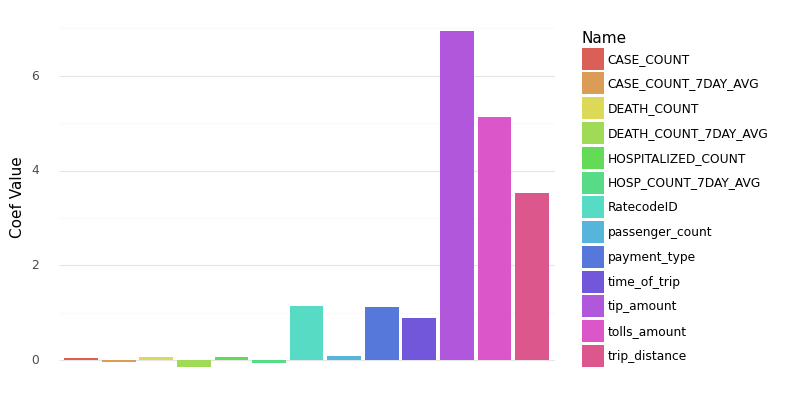

<ggplot: (120521468992)>

In [21]:
coefficients2 = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
ggplot(aes(x="Name", weight="Coef"), coefficients2) + geom_bar(aes(fill = "Name")) + theme_minimal() + labs(x = "Coefficent's Name",y = "Coef Value") + theme(panel_grid_major_x = element_blank(),
        axis_title_x=element_blank(),
        axis_text_x=element_blank())

In [22]:
print(np.mean(mergeSet["total_amount"]))
print(np.std(mergeSet["total_amount"]))
print(np.max(mergeSet["total_amount"]))

18.793118124455663
14.629899632388813
5954.0


In [23]:
predictors = ["CASE_COUNT","HOSPITALIZED_COUNT","DEATH_COUNT","CASE_COUNT_7DAY_AVG","HOSP_COUNT_7DAY_AVG","DEATH_COUNT_7DAY_AVG",
              "passenger_count","trip_distance","time_of_trip","RatecodeID","payment_type","tip_amount","tolls_amount"]

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

predicted = lr.predict(Xz_test)

pca = PCA()
pca.fit(X_train[predictors])

pcaDF = pd.DataFrame({"expl_var" : pca.explained_variance_ratio_, "pc": range(1,14),"cum_var": pca.explained_variance_ratio_.cumsum()})
pcaDF.head()


,expl_var,pc,cum_var
0,0.988039,1,0.988039
1,0.011296,2,0.999336
2,0.000641,3,0.999977
3,0.000017,4,0.999993
4,0.000003,5,0.999997


In [24]:
np.max(pd.DataFrame(pca.components_,columns=X_train.columns,index = range(1,14)))

CASE_COUNT              0.756440
HOSPITALIZED_COUNT      0.053596
DEATH_COUNT             0.262415
CASE_COUNT_7DAY_AVG     0.744055
HOSP_COUNT_7DAY_AVG     0.556026
DEATH_COUNT_7DAY_AVG    0.854238
passenger_count         0.010635
trip_distance           0.985329
time_of_trip            1.000000
RatecodeID              0.997388
payment_type            0.080818
tip_amount              0.143690
tolls_amount            0.961523
dtype: float64

In [25]:
most_important = [np.abs(pca.components_[i]).argmax() for i in range(13)]
most_important_names = [predictors[most_important[i]] for i in range(13)]
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(13)}

df = pd.DataFrame(sorted(dic.items()))
print(df)

       0                     1
0    PC1          time_of_trip
1   PC10  DEATH_COUNT_7DAY_AVG
2   PC11       passenger_count
3   PC12            RatecodeID
4   PC13          payment_type
5    PC2            CASE_COUNT
6    PC3   CASE_COUNT_7DAY_AVG
7    PC4   HOSP_COUNT_7DAY_AVG
8    PC5         trip_distance
9    PC6    HOSPITALIZED_COUNT
10   PC7           DEATH_COUNT
11   PC8            tip_amount
12   PC9          tolls_amount


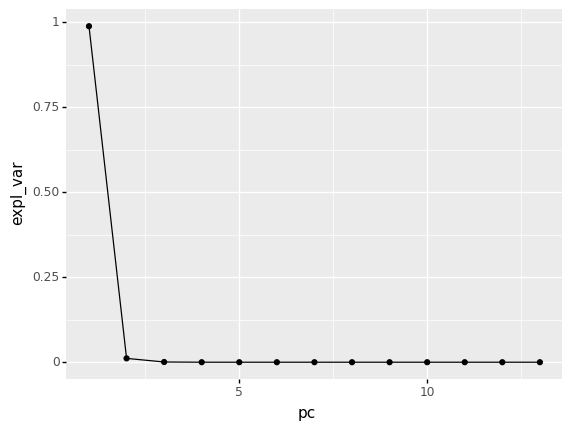

<ggplot: (120518678468)>

In [26]:
(ggplot(pcaDF, aes(x = "pc", y = "expl_var")) + geom_line() + geom_point())

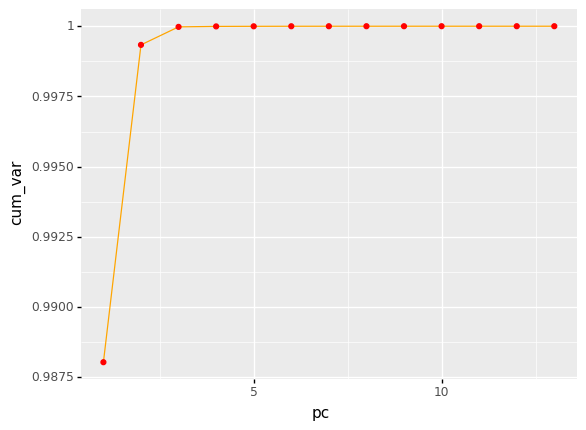

In [27]:
plot2 = (ggplot(pcaDF, aes(x = "pc", y = "cum_var")) + geom_line(color = "Orange") +
 geom_point(color = "Red"))
print(plot2)

In [28]:
predictors = ["DEATH_COUNT_7DAY_AVG","trip_distance","time_of_trip","RatecodeID","tolls_amount"]
# DEATH_COUNT_7DAY_AVG    0.854254
# trip_distance           0.985370
# time_of_trip            1.000000
# RatecodeID              0.997339
# tolls_amount            0.961625

testSplitDecimal = .1

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

y_pred = lr.predict(Xz_test)
y_predTrain = lr.predict(Xz_train)


testMSE = mean_squared_error(y_test,y_pred)
trainMSE = mean_squared_error(y_train,y_predTrain)

testr2 = r2_score(y_test,y_pred)
trainr2 = r2_score(y_train,y_predTrain)


coefficients = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
print(coefficients)

print("TEST")
print(testMSE)
print(testr2)

print("TRAIN")
print(trainr2)
print(trainMSE)

       Coef                  Name
0 -0.206287  DEATH_COUNT_7DAY_AVG
1  4.938502         trip_distance
2  1.134426          time_of_trip
3  1.531646            RatecodeID
4  7.021592          tolls_amount
TEST
91.1573162178448
0.5654695258409541
TRAIN
0.49136044044328275
109.10635905817614


In [29]:
predictors = ["CASE_COUNT","CASE_COUNT_7DAY_AVG","HOSP_COUNT_7DAY_AVG",
              "trip_distance","time_of_trip"]
# PC1          time_of_trip
# PC2            CASE_COUNT
# PC3   CASE_COUNT_7DAY_AVG
# PC4   HOSP_COUNT_7DAY_AVG
# PC5         trip_distance

testSplitDecimal = .1

X_train, X_test, y_train, y_test = train_test_split(mergeSet[predictors], mergeSet["total_amount"],
                                                    test_size=testSplitDecimal)

zScore = StandardScaler()

zScore.fit(X_train)
Xz_train = zScore.transform(X_train)
Xz_test = zScore.transform(X_test)


lr = LinearRegression()
lr.fit(Xz_train,y_train)

y_pred = lr.predict(Xz_test)
y_predTrain = lr.predict(Xz_train)


testMSE = mean_squared_error(y_test,y_pred)
trainMSE = mean_squared_error(y_train,y_predTrain)

testr2 = r2_score(y_test,y_pred)
trainr2 = r2_score(y_train,y_predTrain)


coefficients = pd.DataFrame({"Coef":lr.coef_,
              "Name": predictors})
print(coefficients)

print("TEST")
print(testMSE)
print(testr2)

print("TRAIN")
print(trainr2)
print(trainMSE)

       Coef                 Name
0  0.073715           CASE_COUNT
1  0.255373  CASE_COUNT_7DAY_AVG
2 -0.488207  HOSP_COUNT_7DAY_AVG
3  7.258535        trip_distance
4  1.471880         time_of_trip
TEST
123.67380680621392
0.4081212181114472
TRAIN
0.2650466148967985
157.7200356373084


## b) ##

Based on the comparison between the PCA and linear model, there is not too much that changes after using PCA. This is shown by the very VERY high cumulative variation shown just by one variable that shows that time is the most important variable and that the others dont matter as much in terms of explaining the same amount of variation in the data.

When comparing the model using one month of data, its better to not include COVID data as the resulting model both for a simple linear model and when including PCA and using the top 5 variables is worse.

I would state that this doesn’t show a impact or a lack of impact that COVID had on the taxi business. I would say that it added too much to something that it wouldn’t have a impact on. It logically makes sense that this model wouldnt work better with coivd data as covid data has intuitivly nothing to do with the total transaction cost of each individual ride.

Something that it could possibly have a impact on is the transaction count overall and i will dive into that with question #3.5

## c) ##

The first plot is the coefficent values of the coefficents that were created from the linear model made from the variables from the TAXI dataset

The second plot is the coefficent values of the coefficents that were created from the linear model made from the variables from the TAXI and COVID dataset

PLOT #1


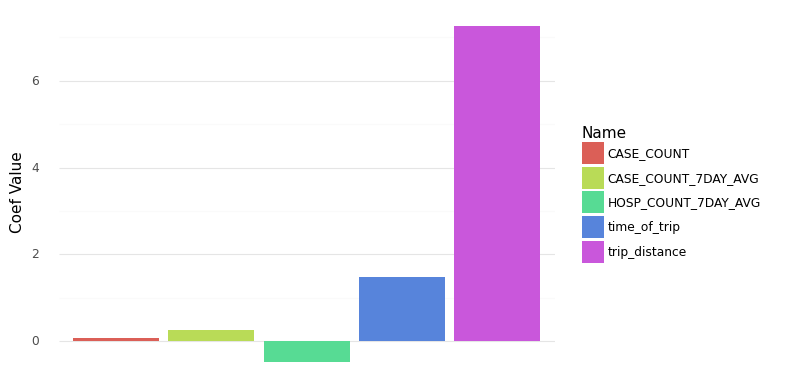


PLOT #2


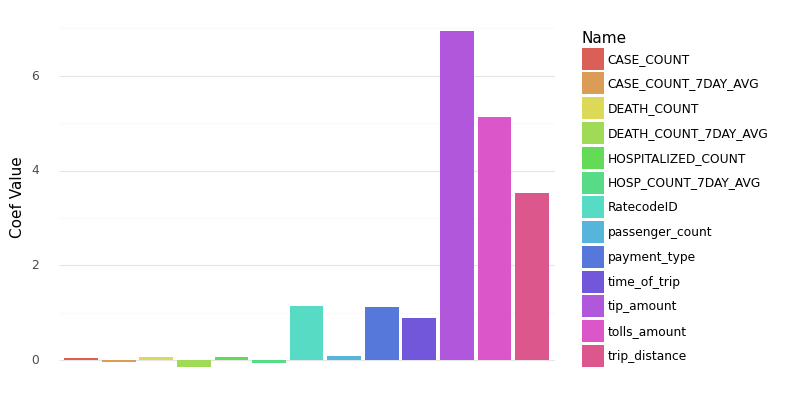

In [30]:
print("PLOT #1")
print(ggplot(aes(x="Name", weight="Coef"), coefficients) + geom_bar(aes(fill = "Name")) + theme_minimal() + labs(x = "Coefficent's Name",y = "Coef Value") + theme(panel_grid_major_x = element_blank(),
        axis_title_x=element_blank(),
        axis_text_x=element_blank()))
print("PLOT #2")
print(ggplot(aes(x="Name", weight="Coef"), coefficients2) + geom_bar(aes(fill = "Name")) + theme_minimal() + labs(x = "Coefficent's Name",y = "Coef Value") + theme(panel_grid_major_x = element_blank(),
        axis_title_x=element_blank(),
        axis_text_x=element_blank()))

The first plot below is the Cumulative Varriation graph for the TAXI only PCA. This graph marks the importance of each Commonent or Variable in the graph.

The second plot below is the Cumulative Varriation graph for the TAXI and COVID PCA. This graph marks the importance of each Commonent or Variable in the graph.

Notice the insanely high .999999 that both start at. This shows that there is one varriable that has insanely high improtantce and the other ones are much less important

PLOT #3


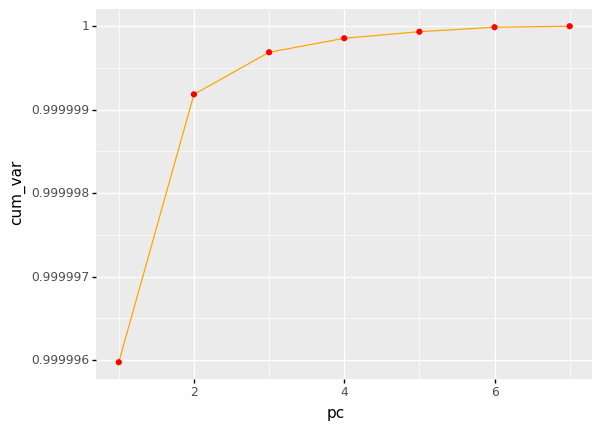


PLOT #4


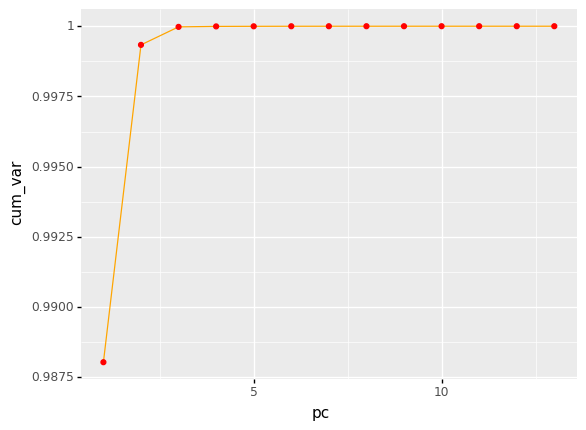

In [31]:
print("PLOT #3")
print(plot1)
print("PLOT #4")
print(plot2)